In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from numpy.linalg import norm

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('dataset.csv', index_col=0)
df = df.drop_duplicates()
df = df.drop_duplicates(subset=['track_id'])
df = df.drop_duplicates(subset=['artists', 'track_name'])
df = df[df['duration_ms'] != 0]
df['explicit'] = df['explicit'].astype(int)

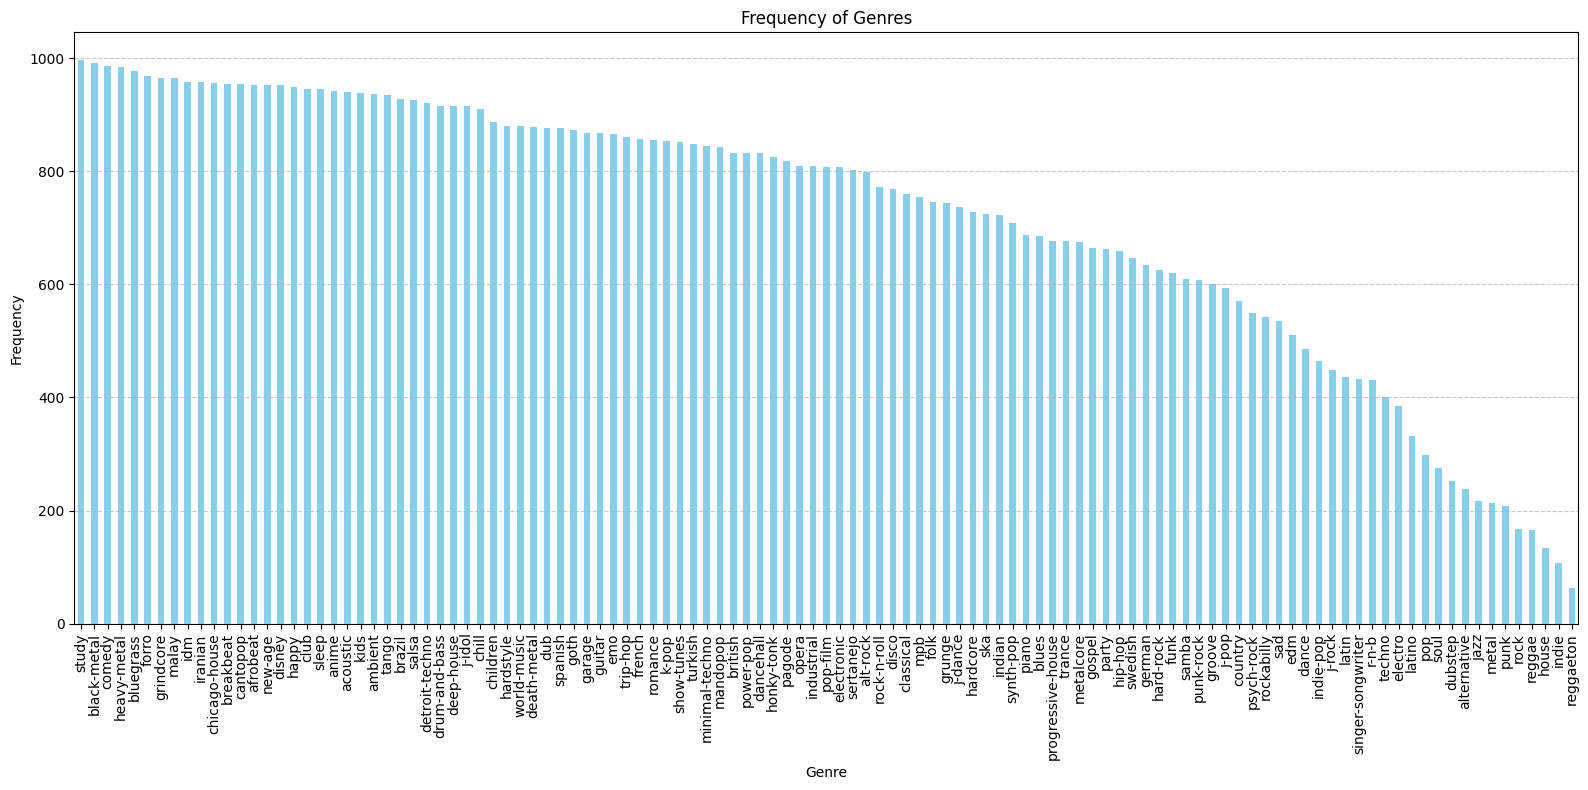

In [3]:
genre_frequency = df['track_genre'].value_counts()

plt.figure(figsize=(16, 8))
genre_frequency.plot(kind='bar', color='skyblue')
plt.title('Frequency of Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  

plt.show()

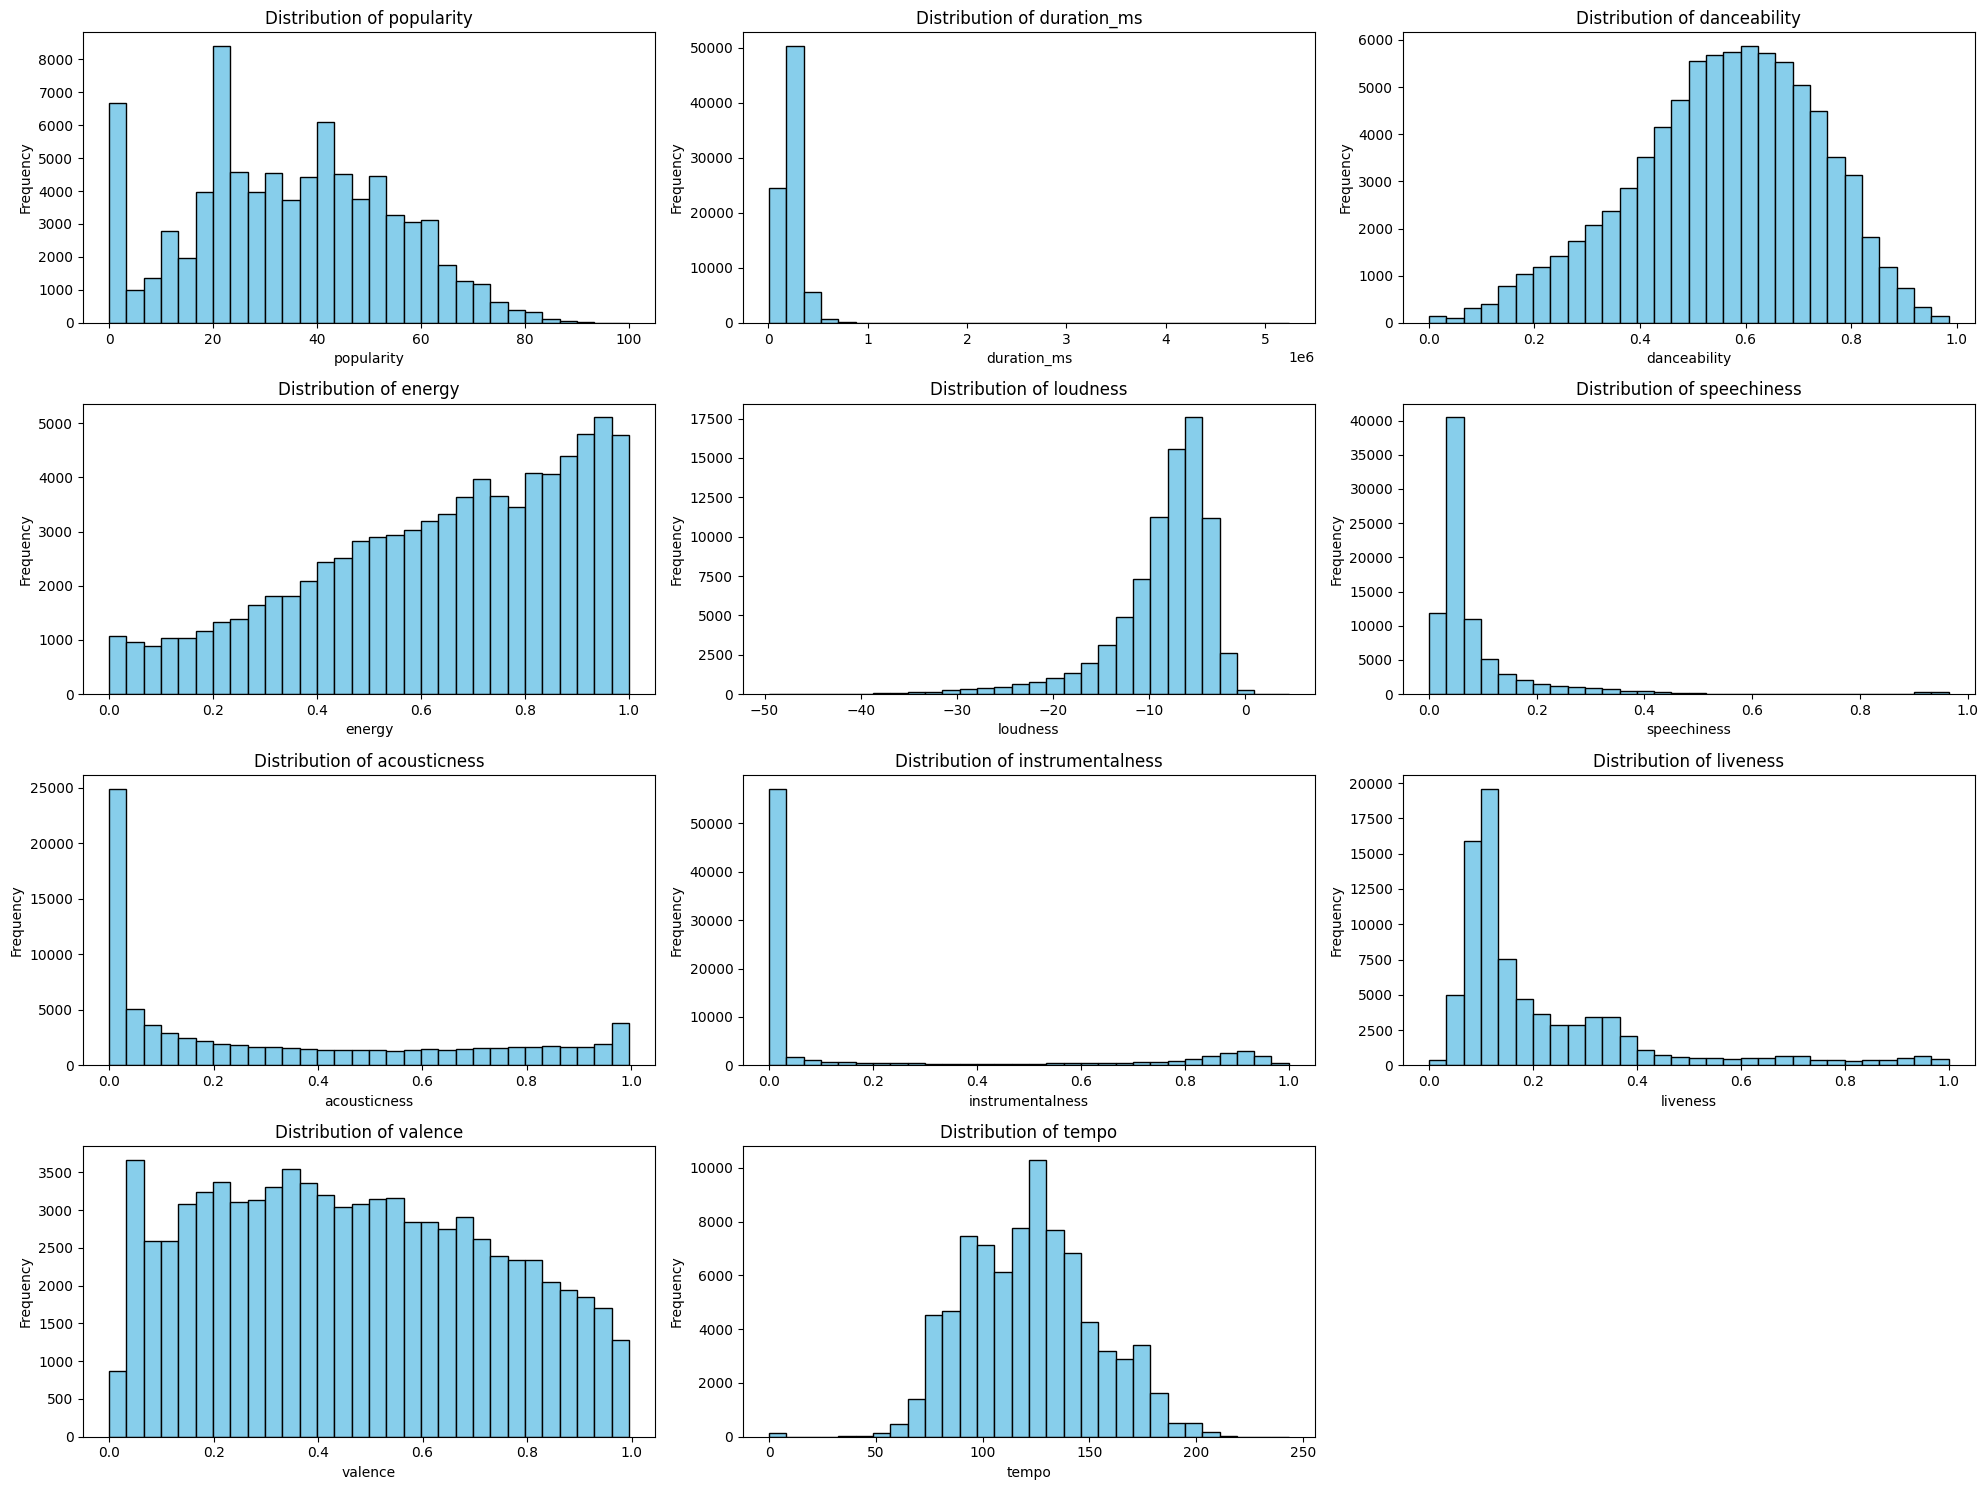

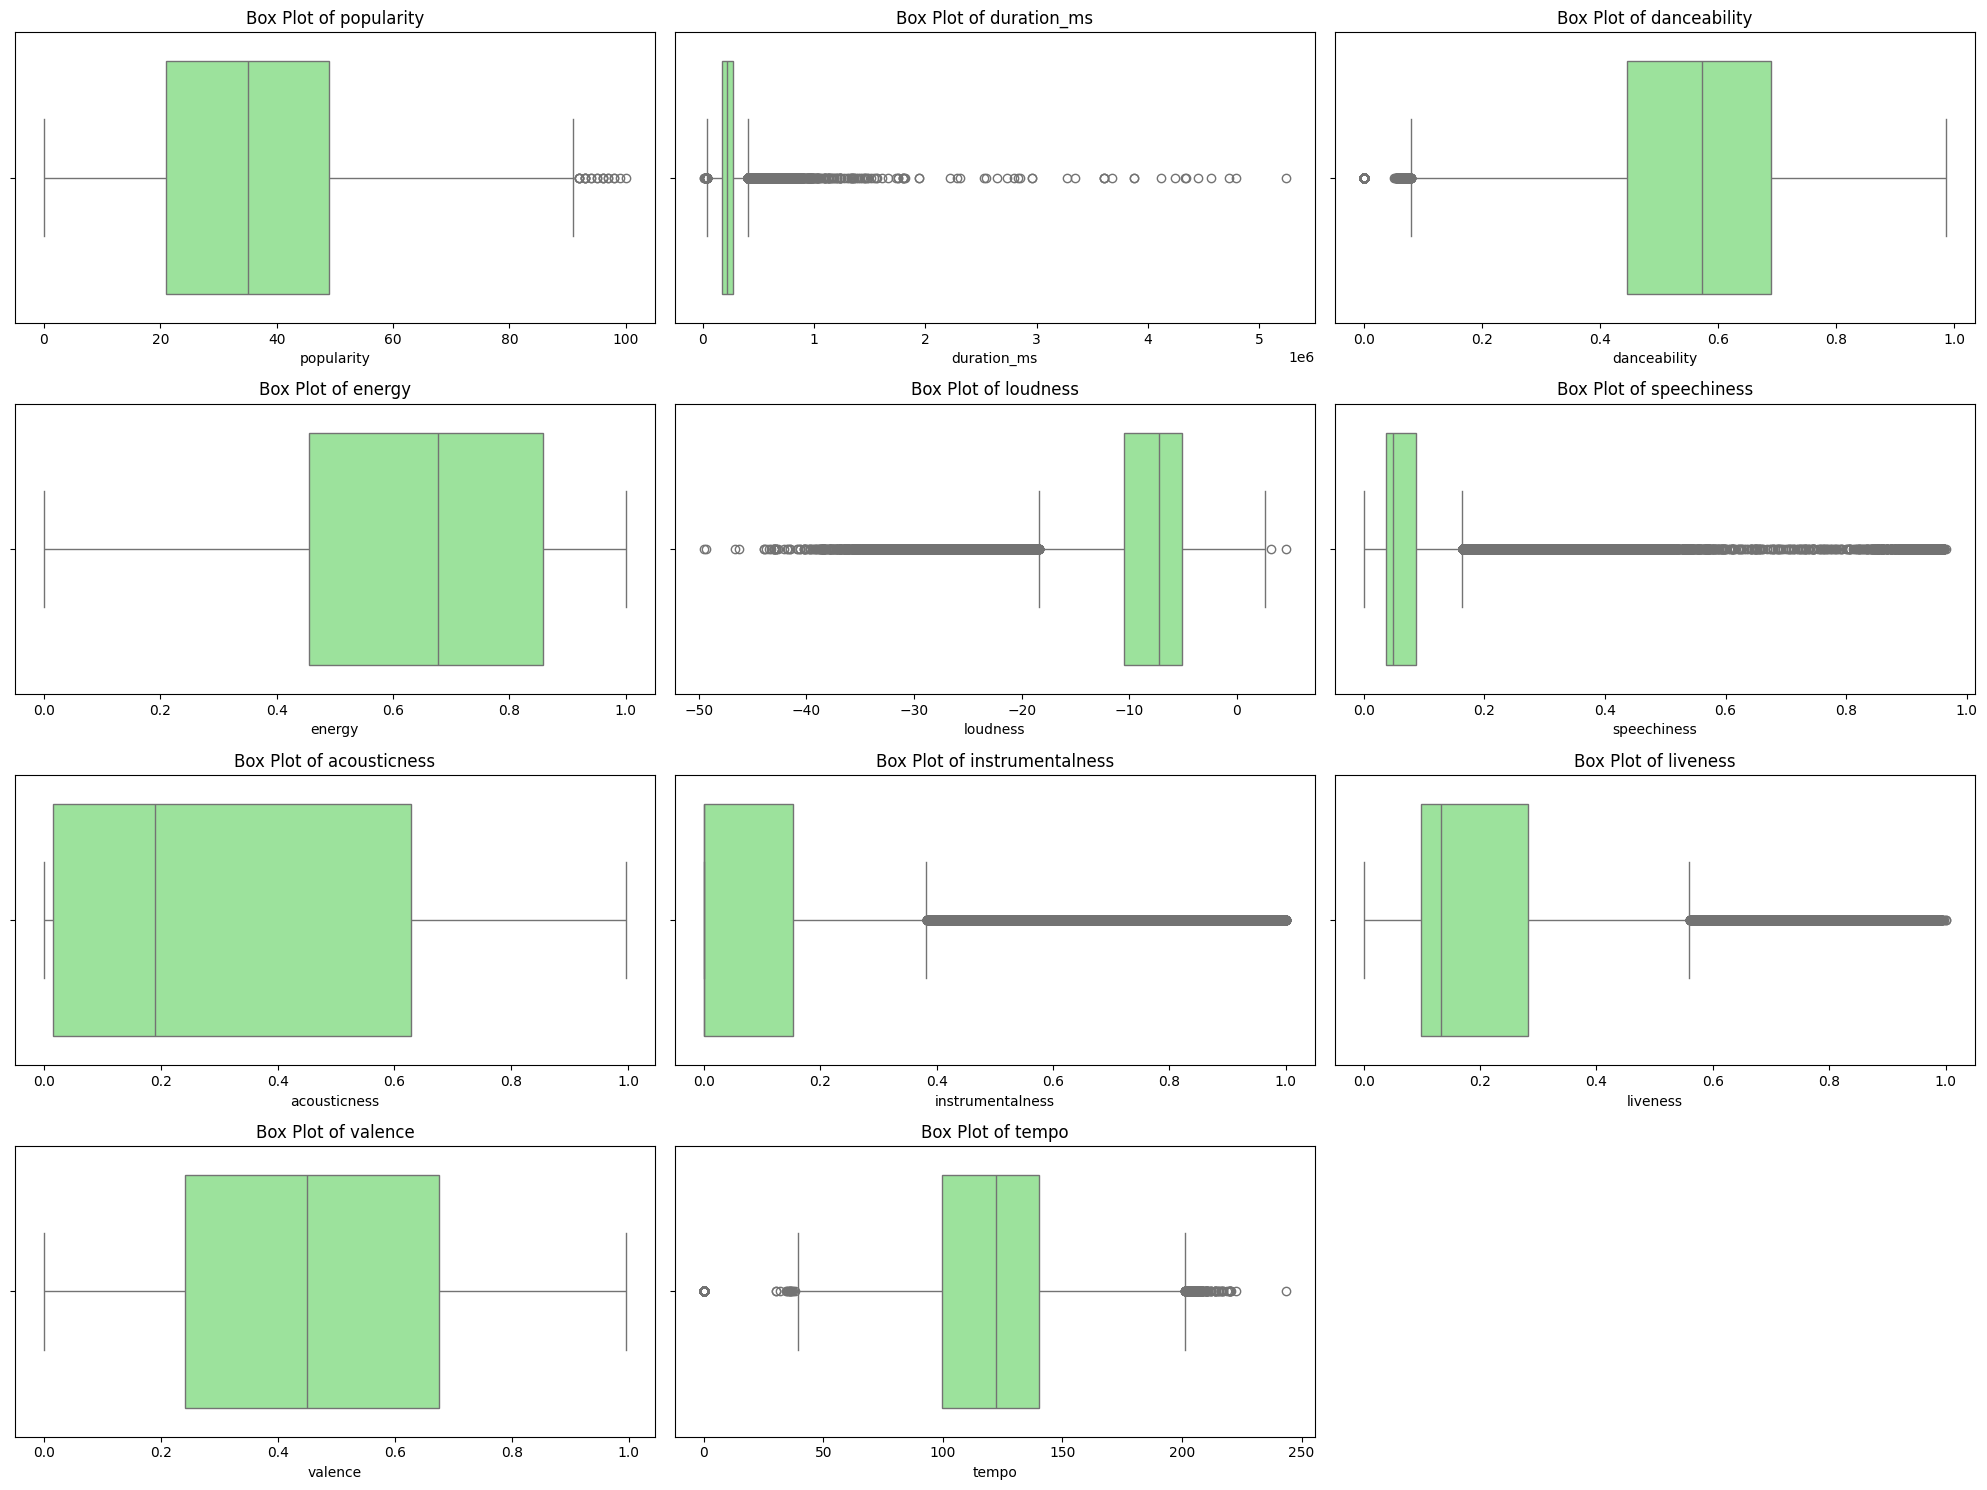

In [4]:
features = df.drop(columns=['track_id']).columns

numerical_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 
    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
    'valence', 'tempo'
]

categorical_features = [
    'artists', 'album_name', 'track_name'
]


plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i + 1)
    plt.hist(df[feature], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=df[feature], color='lightgreen')
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()



In [5]:
features_to_normalize = [
    'popularity', 'duration_ms', 'loudness', 'tempo', 'time_signature'
]

def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())

df_normalized = df.copy()
for col in features_to_normalize:
    df_normalized[col] = min_max_scaling(df[col])


# df_one_hot_encoded = df_normalized.copy()
df_one_hot_encoded = pd.get_dummies(df_normalized, columns=['key'], drop_first=True)
one_hot_columns = [col for col in df_one_hot_encoded.columns if col.startswith('key_')]
df_one_hot_encoded[one_hot_columns] = df_one_hot_encoded[one_hot_columns].astype(int)


In [6]:
df_shuffled = df_one_hot_encoded.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = int(0.8 * len(df_shuffled))
test_size = int(0.1 * len(df_shuffled))
val_size = 100 - train_size - test_size

train_df = df_shuffled[:train_size]
test_df = df_shuffled[train_size:train_size + test_size]
val_df = df_shuffled[train_size + test_size:]

train_X = train_df.drop(columns=['track_genre', 'track_id', 'artists', 'album_name', 'track_name', 'explicit'])
train_y = train_df['track_genre']

test_X = test_df.drop(columns=['track_genre', 'track_id', 'artists', 'album_name', 'track_name', 'explicit'])
test_y = test_df['track_genre']

val_X = val_df.drop(columns=['track_genre', 'track_id', 'artists', 'album_name', 'track_name', 'explicit'])
val_y = val_df['track_genre']

In [7]:
class Initial_KNN:
    def __init__(self, k, distance_metric):
        self.k = k
        self.distance_metric = distance_metric
    
    def get_k(self):
        return self.k
    def set_k(self, k):
        self.k = k

    def get_distance_metric(self):
        return self.distance_metric
    def set_distance_metric(self, distance_metric):
        self.distance_metric = distance_metric

    def calculate_distance(self, X_train, sample):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((X_train - sample) ** 2, axis=1))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(X_train - sample), axis=1)
        elif self.distance_metric == 'cosine':
            cosine_similarity = np.dot(X_train, sample) / (norm(X_train, axis=1) * norm(sample))
            return 1 - cosine_similarity
        else:
            raise ValueError("Invalid Distance Metric.")
        
    def fit(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def predict_sample(self, sample):
        distances = self.calculate_distance(self.X_train, sample)
        k_indices = np.argpartition(distances, self.k)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]

        return most_common_label
    
    def predict(self):
        predictions = [self.predict_sample(sample) for sample in self.X_val]
        return np.array(predictions)

    
    def accuracy(self):
        predictions = self.predict()
    
        return np.sum(predictions == self.y_val) / len(self.y_val)
    
knn = Initial_KNN(5, 'manhattan')
knn.fit(train_X.to_numpy(), train_y.to_numpy(), val_X.to_numpy(), val_y.to_numpy())
print(knn.accuracy())


0.19864781807006762
